In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import scipy
import ipynb.fs
import pandas as pd

from ipynb.fs.defs.BCI_COMP_IV_functions import (extractInfo, featureExtraction, createFilterBank,
                                                testWindowLength, testClassifier, testFrequencyBand,
                                                testWindowStartTime, startRunningClassifier)


In [2]:
dataB = scipy.io.loadmat("BCICIV_1_mat/BCICIV_calib_ds1b.mat")

dataB["cnt"] = 0.1 * dataB["cnt"].astype(float)

eeg = dataB["cnt"].T 
nChannels, nSamples = eeg.shape

calibDataStore, testData, _, comp = featureExtraction(dataB,0.7)



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Base Classification

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve, auc, accuracy_score


ldaModel = LDA()
SVMmodel = SVC(probability=True) #Change class weights back to balanced if necessary
logRegModel = LogisticRegression() #Change class weights back to balanced



In [4]:

for name, calibData in calibDataStore.items():
    
    nCols = len(calibData.columns)
    print(name,end="\n")
    print("-----------")

    print("LDA: ",np.mean(cross_val_score(ldaModel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print("Logistic Regression: ",np.mean(cross_val_score(logRegModel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print("SVM: ",np.mean(cross_val_score(SVMmodel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print()


RO
-----------
LDA:  0.8253694581280788
Logistic Regression:  0.8248768472906404
SVM:  0.8179802955665025

SMOTE
-----------
LDA:  0.8325123152709359
Logistic Regression:  0.8179802955665025
SVM:  0.8179802955665025

RU
-----------
LDA:  0.8126984126984127
Logistic Regression:  0.8124338624338623
SVM:  0.8341269841269842

CC
-----------
LDA:  0.8124338624338625
Logistic Regression:  0.8052910052910052
SVM:  0.8198412698412698

None
-----------
LDA:  0.8071428571428573
Logistic Regression:  0.8142857142857144
SVM:  0.8142857142857144



In [5]:
print("Performance on test data - Untuned models")
print()
#Do not use crossValidtation on test data
for model in [ldaModel,SVMmodel,logRegModel]:
    print(type(model).__name__)
    print("----------------")
    for name, calibData in calibDataStore.items():
        #cross val score does not fit mode hence, the need to fit the model on the training data
        model.fit(calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1])
        print(f"{name} = {np.mean(accuracy_score(model.predict(testData.iloc[:,:nCols-1]), testData.iloc[:,nCols-1]))}")
    print()

Performance on test data - Untuned models

LinearDiscriminantAnalysis
----------------
RO = 0.85
SMOTE = 0.85
RU = 0.8666666666666667
CC = 0.85
None = 0.85

SVC
----------------
RO = 0.8333333333333334
SMOTE = 0.8333333333333334
RU = 0.8333333333333334
CC = 0.8333333333333334
None = 0.8333333333333334

LogisticRegression
----------------
RO = 0.85
SMOTE = 0.85
RU = 0.8333333333333334
CC = 0.85
None = 0.8333333333333334



### Tuned Classification

In [6]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

print("LDA - Tuned")
print("-------")
best_LDA_resamp_estimator = None
for name, calibData in calibDataStore.items():

    #  Set the parameter grid for grid search
    param_grid = {'solver': ['svd', 'lsqr', 'eigen'],'shrinkage': np.arange(0,1,0.1)}

    # Create the grid search object
    gridLDA = GridSearchCV(estimator=LDA(), param_grid=param_grid,scoring="accuracy", cv=5)

    # Fit the grid search to the data
    gridLDA.fit(calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1])

    # Get the best hyperparameters
    #print(gridLDA.best_params_)

    # Get the best score
    print(f"{name} {gridLDA.best_score_}")
    print()

    if not best_LDA_resamp_estimator:
        best_LDA_resamp_estimator = (gridLDA.best_estimator_,gridLDA.best_score_)

    elif gridLDA.best_score_ > best_LDA_resamp_estimator[1]:
        best_LDA_resamp_estimator = (gridLDA.best_estimator_,gridLDA.best_score_)



LDA - Tuned
-------
RO 0.8320197044334975

SMOTE 0.8325123152709359

RU 0.8269841269841269

CC 0.8343915343915344

None 0.8285714285714286



In [7]:
print("Logistic Regression -  Tuned")
print("-------------------")
best_logReg_resamp_estimator = None
for name, calibData in calibDataStore.items():

    #Set the parameter grid for grid search
    param_grid = {'penalty': ['l1','l2'], 'C':list(np.logspace(-3,3)), 'solver': ['newton-cg', 'lbfgs', 'liblinear']}

    # Create the grid search object
    gridLogReg = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid,scoring='accuracy', cv=5)#Change class weights back to balanced

    # Fit the grid search to the data
    gridLogReg.fit(calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1])

    # Get the best hyperparameters
    #print(gridLogReg.best_params_)

    # Get the best score
    print(f"{name} {gridLogReg.best_score_}")
    print()

    if not best_logReg_resamp_estimator:
        best_logReg_resamp_estimator = (gridLogReg.best_estimator_, gridLogReg.best_score_)

    elif gridLogReg.best_score_ > best_logReg_resamp_estimator[1]:
        best_logReg_resamp_estimator = (gridLogReg.best_estimator_, gridLogReg.best_score_)


Logistic Regression -  Tuned
-------------------
RO 0.8463054187192117

SMOTE 0.8463054187192117

RU 0.8486772486772487

CC 0.8417989417989418

None 0.8428571428571429



In [8]:
print("SVM")
print("----")
best_SVM_resamp_estimator = None
for name, calibData in calibDataStore.items():

    #Set the parameter grid for grid search
    param_grid = {'C': [0.0001,0.001,0.01,1,10,100,1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel':["rbf","linear"]}

    # Create the grid search object
    gridSVM = GridSearchCV(estimator=SVC(probability=True), param_grid=param_grid,scoring="accuracy", cv=5) #Change class weights back to balanced

    # Fit the grid search to the data
    gridSVM.fit(calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1])

    # Get the best hyperparameters
    #print(gridSVM.best_params_)

    # Get the best score
    print(f"{name} {gridSVM.best_score_}")
    print()

    if not best_SVM_resamp_estimator:
        best_SVM_resamp_estimator = (gridSVM.best_estimator_,gridSVM.best_score_)
        
    elif gridSVM.best_score_ > best_SVM_resamp_estimator[1]:
        best_SVM_resamp_estimator = (gridSVM.best_estimator_,gridSVM.best_score_)



SVM
----
RO 0.8394088669950739

SMOTE 0.8394088669950739

RU 0.8415343915343915

CC 0.8272486772486772

None 0.8357142857142857



In [9]:
for model in [best_LDA_resamp_estimator[0],best_SVM_resamp_estimator[0],best_logReg_resamp_estimator[0]]:
    print(type(model).__name__)
    print("----------------")
    for name, calibData in calibDataStore.items():
        #model has already been fit
        print(f"{name} = {np.mean(accuracy_score(model.predict(testData.iloc[:,:nCols-1]), testData.iloc[:,nCols-1]))}")
    print()


LinearDiscriminantAnalysis
----------------
RO = 0.8333333333333334
SMOTE = 0.8333333333333334
RU = 0.8333333333333334
CC = 0.8333333333333334
None = 0.8333333333333334

SVC
----------------
RO = 0.8166666666666667
SMOTE = 0.8166666666666667
RU = 0.8166666666666667
CC = 0.8166666666666667
None = 0.8166666666666667

LogisticRegression
----------------
RO = 0.85
SMOTE = 0.85
RU = 0.85
CC = 0.85
None = 0.85



### Window Length test

### Accuracy

In [11]:
# _, _ = testWindowLength(dataB,
#                 ["Logistic Regression","LDA","SVC"],
#                 0.8)

### Window Start time test

### Accuracy

In [12]:
# bestEstimator_start_time, W_start_time = testWindowStartTime(dataB,
#                     ["Logistic Regression","LDA","SVC"],
#                     0.8,
#                     4.5)


###Test all combinations of window start and length?

In [13]:
#bestEstimator_start_time

### Investigating the effect of varying the frquency band 

In [11]:
channelNames,sRate,classLabels,eventOnsets,eventCodes,labels = extractInfo(dataB,nSamples)

filterBank = createFilterBank(sRate)

bestBand_RU, bestEstimator_freq_band_RU, (best_b_RU, best_a_RU), W_freq_band_RU = testFrequencyBand(dataB,["Logistic Regression","LDA","SVC"],filterBank,0.7,trialWinStart=0.5,trialWinEnd=2.5,resampler="RU")
bestBand_RU

8-12 : 0.8486772486772487
8-15 : 0.8404761904761905
13-30 : 0.7817460317460317


(8, 12)

In [12]:
bestEstimator_freq_band_RU

LogisticRegression(C=0.022229964825261943, solver='liblinear')

In [13]:
bestBand_RO, bestEstimator_freq_band_RO, (best_b_RO, best_a_RO), W_freq_band_RO = testFrequencyBand(dataB,["Logistic Regression","LDA","SVC"],filterBank,0.7,trialWinStart=0.5,trialWinEnd=2.5,resampler="RO")
bestBand_RO


8-12 : 0.8463054187192117
8-15 : 0.8305418719211822
13-30 : 0.7822660098522168


(8, 12)

In [14]:
bestEstimator_freq_band_RO


LogisticRegression(C=0.012648552168552958, solver='liblinear')

In [15]:
bestBand_SMOTE, bestEstimator_freq_band_SMOTE, (best_b_SMOTE, best_a_SMOTE), W_freq_band_SMOTE = testFrequencyBand(dataB,["Logistic Regression","LDA","SVC"],filterBank,0.7,trialWinStart=0.5,trialWinEnd=2.5,resampler="SMOTE")
bestBand_SMOTE


8-12 : 0.8463054187192117
8-15 : 0.8379310344827587
13-30 : 0.7820197044334976


(8, 12)

In [16]:
bestEstimator_freq_band_RO


LogisticRegression(C=0.012648552168552958, solver='liblinear')

In [32]:
bestBand_CC, bestEstimator_freq_band_CC, (best_b_CC, best_a_CC), W_freq_band_CC = testFrequencyBand(dataB,["Logistic Regression","LDA","SVC"],filterBank,0.7,trialWinStart=0.5,trialWinEnd=2.5,resampler="CC")
bestBand_CC


8-12 : 0.8417989417989418
8-15 : 0.8335978835978836
13-30 : 0.783068783068783


(8, 12)

In [33]:
bestEstimator_freq_band_CC

LogisticRegression(C=0.09102981779915217, penalty='l1', solver='liblinear')

In [19]:
bestBand_NoResampler, bestEstimator_freq_band_NoResampler, (best_b_NoResampler, best_a_NoResampler), W_freq_band_NoResampler = testFrequencyBand(dataB,["Logistic Regression","LDA","SVC"],filterBank,0.7,trialWinStart=0.5,trialWinEnd=2.5,resampler="None")
bestBand_NoResampler


8-12 : 0.8428571428571429
8-15 : 0.8428571428571429
13-30 : 0.7857142857142858


(8, 12)

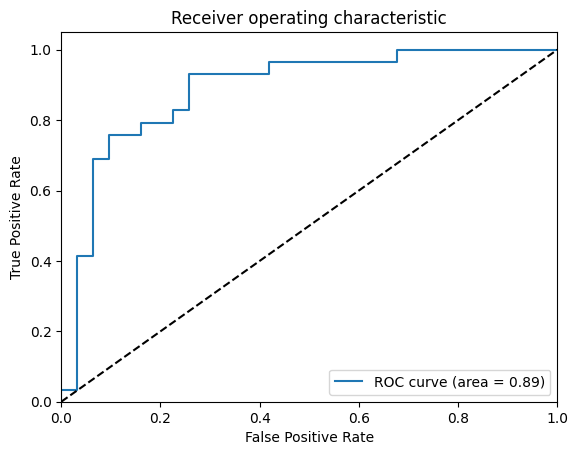

In [35]:

probs = cross_val_predict(bestEstimator_freq_band_NoResampler,testData.iloc[:,:nCols-1], testData.iloc[:,nCols-1],cv=5, method="predict_proba")
probs = probs[:, 1]  # use the probability of the positive class
true_labels = testData.iloc[:,nCols-1]

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(true_labels, probs)
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [21]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"No resampler otimal threshold : {optimal_threshold}")

#to determine whether the difference between two class probabilities is 
# large enough to make a definitive prediction for one class , you would 
# compare the difference in probabilities to your chosen decision threshold. 
# If the difference in probabilities is greater than the decision threshold, 
# you would predict the class with the higher probability. 
# If the difference in probabilities is less than the decision threshold,
#  you may want to withhold making a prediction or seek further information to make a more informed decision.


No resampler otimal threshold : 0.48663474871332646


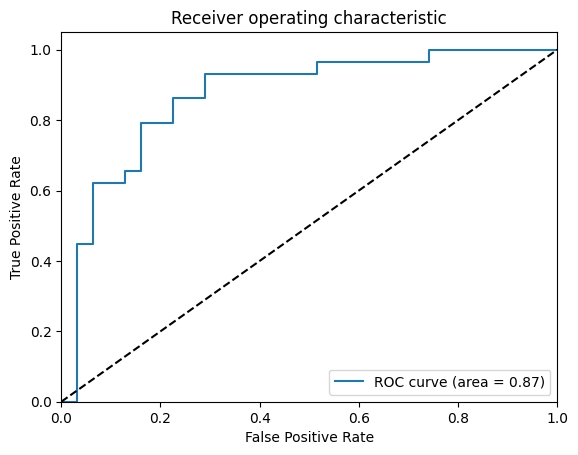

In [22]:

probs = cross_val_predict(bestEstimator_freq_band_RO,testData.iloc[:,:nCols-1], testData.iloc[:,nCols-1],cv=5, method="predict_proba")
probs = probs[:, 1]  # use the probability of the positive class
true_labels = testData.iloc[:,nCols-1]

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(true_labels, probs)
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [23]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Random Oversampling otimal threshold : {optimal_threshold}")


Random Oversampling otimal threshold : 0.4929278775702966


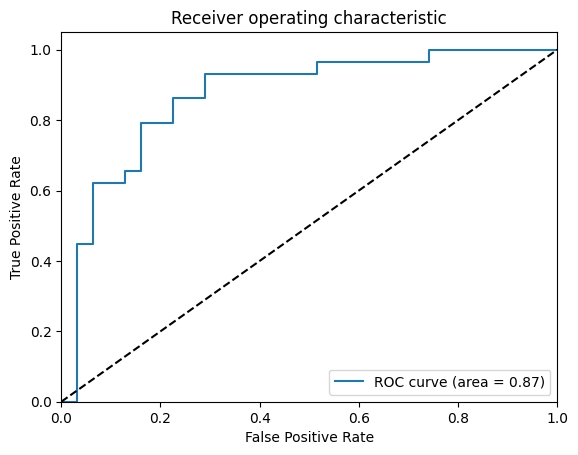

In [24]:
probs = cross_val_predict(bestEstimator_freq_band_SMOTE,testData.iloc[:,:nCols-1], testData.iloc[:,nCols-1],cv=5, method="predict_proba")
probs = probs[:, 1]  # use the probability of the positive class
true_labels = testData.iloc[:,nCols-1]

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(true_labels, probs)
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [25]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"SMOTE otimal threshold : {optimal_threshold}")


SMOTE otimal threshold : 0.4929278775702966


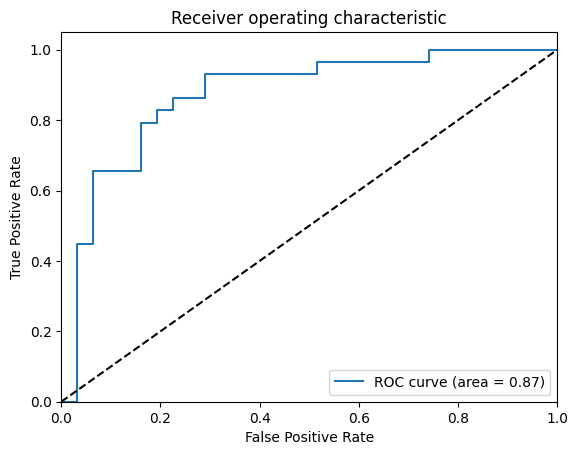

In [26]:
probs = cross_val_predict(bestEstimator_freq_band_RU,testData.iloc[:,:nCols-1], testData.iloc[:,nCols-1],cv=5, method="predict_proba")
probs = probs[:, 1]  # use the probability of the positive class
true_labels = testData.iloc[:,nCols-1]

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(true_labels, probs)
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [28]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Random Undersampling otimal threshold : {optimal_threshold}")


Random Undersampling otimal threshold : 0.4907425427730678


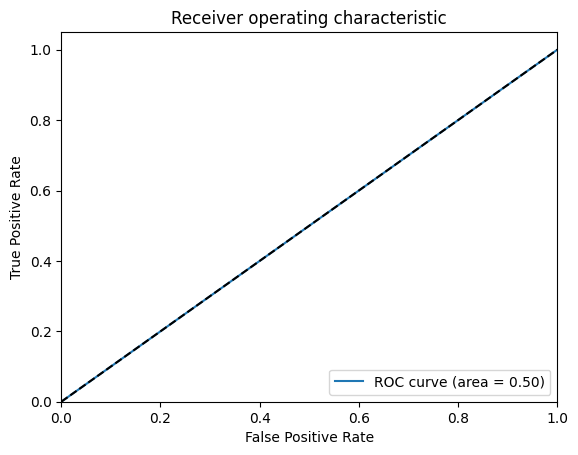

In [37]:
probs = cross_val_predict(bestEstimator_freq_band_CC,testData.iloc[:,:nCols-1], testData.iloc[:,nCols-1],cv=5, method="predict_proba")
probs = probs[:, 1]  # use the probability of the positive class
true_labels = testData.iloc[:,nCols-1]

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(true_labels, probs)
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [36]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Cluster Centroid otimal threshold : {optimal_threshold}")


Cluster Centroid otimal threshold : 0.48663474871332646


### Person's Correlation Coefficient (PCC) + CSP

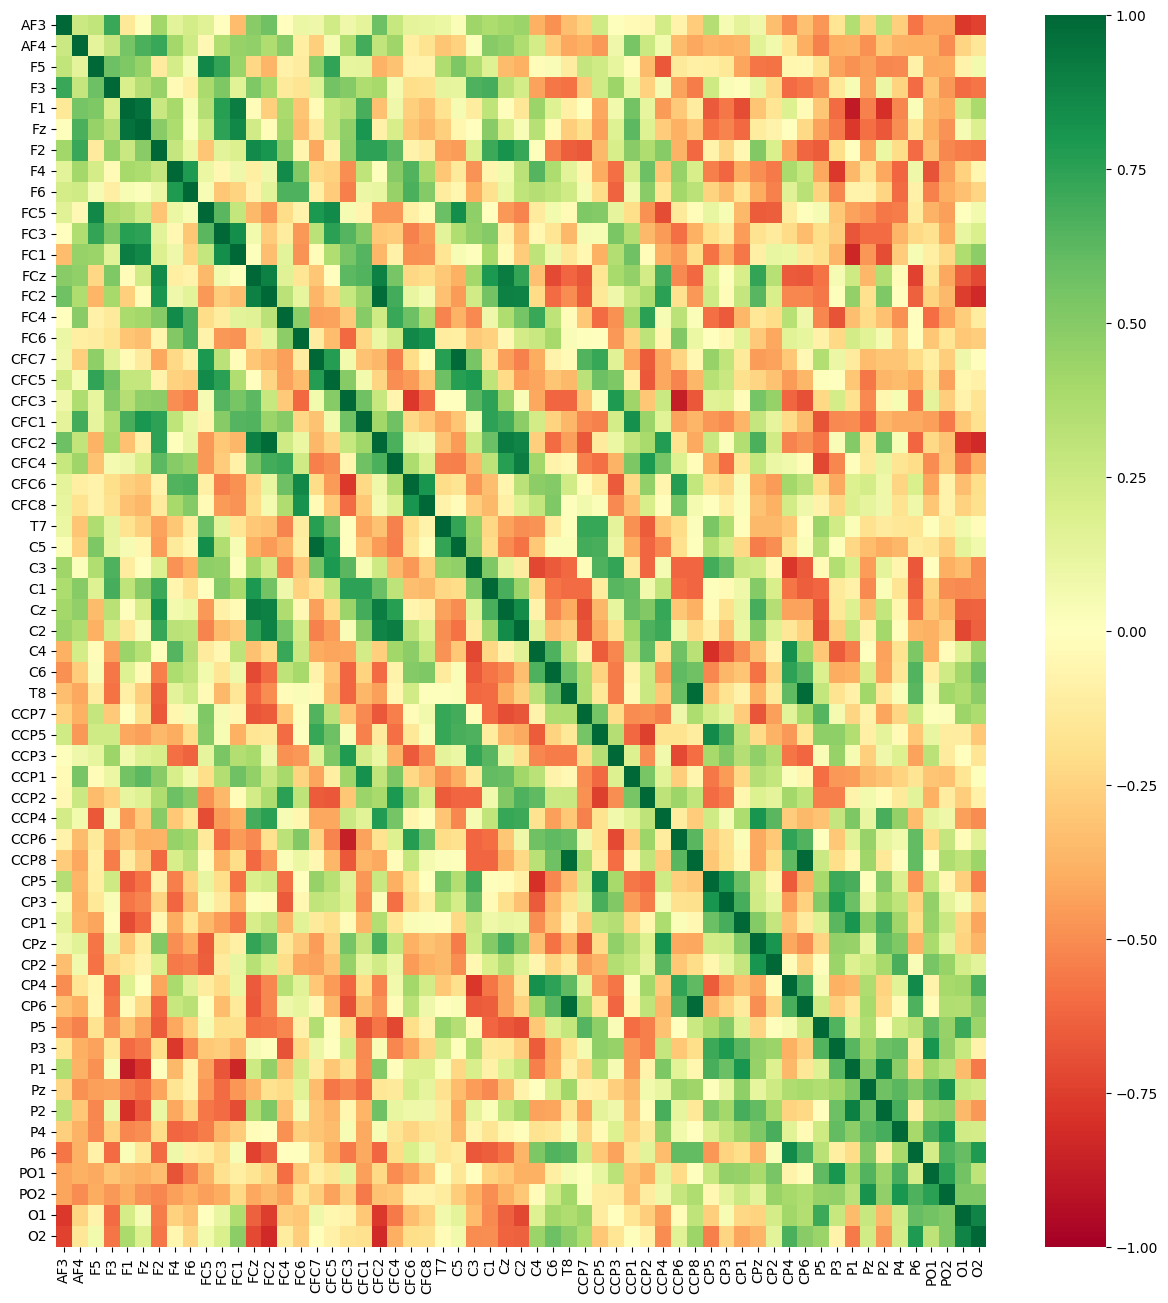

In [18]:
#Plot distributions of channels against eachother
# to find out if there is any sort of positive correlation
# between channels

trialWin = np.arange(int(0.5*sRate),int(2.5*sRate))

# #get mixed trial data from original
trials_mixed = np.zeros(
            (nChannels, len(eventOnsets[0]), len(trialWin)))


for i, onset in enumerate(eventOnsets[0]):
    trials_mixed[:,i,:] = eeg[:,onset+trialWin]

# By augmenting the algorithm outlined in [ref: Electroencephalogram channel selection based on pearson correlation coefficient for motor imagery-brain-computer interface]
# we can able to extract the most correlated channels in the given data prior to selecting features with the CSP algorithm.

from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns

scaler = StandardScaler()

# For each trial
#We must standardize the values in each trial window for each channel (We use z-score normalization for this) 
_, nTrials, _ = trials_mixed.shape

trialChannelCorrelations = []

plotFirst = False #flag to check that heatmap of first trial is plotted 

for trial in range(nTrials):
 
    zTrial = scaler.fit_transform(trials_mixed[:,trial,:])
    corrMat = np.corrcoef(zTrial)

    if not plotFirst:
        plt.figure(figsize=(15, 16))
        sns.heatmap(pd.DataFrame(corrMat,columns=channelNames,index=channelNames),cmap="RdYlGn",vmin=-1,vmax=1)
        plotFirst = True
    
#     # We must then calculate the correlation matrices for each trial and return the mean for each row, giving us a vector of mean values
#     # which represents the average corellation values for a specific channel in relation to other channels.
    channelCorrValues = {ch:corrMean for (ch,corrMean) in zip(channelNames,np.mean(corrMat,axis=1))}

#     #Following the above referenced paper, we select the first 14 channels

    channelCorrValues = dict(sorted(channelCorrValues.items(), key=lambda x:x[1], reverse=True)[:14])
    trialChannelCorrelations.append(channelCorrValues)
    

<AxesSubplot: >

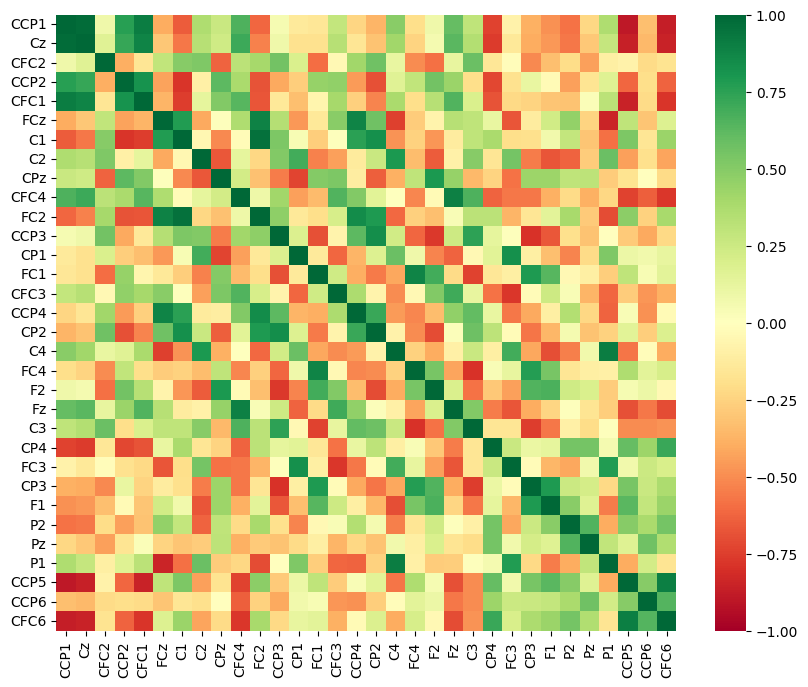

In [19]:
from collections import defaultdict

channelOccurences = defaultdict(int)

for dic in trialChannelCorrelations:
    for ch, _ in dic.items():
        channelOccurences[ch] += 1


# This represent the most correlated channels ordered (descinding) by the number of time they appear
# in the most correlated channel list for each trial
channelOccurences = dict(sorted(channelOccurences.items(), key=lambda x:x[1], reverse=True))

selectedChannels = list(channelOccurences.keys())[:32]
# #It can be seen that all selected channels are in and around the sensorimotor cortex

selectedSet = set(selectedChannels)
selectedIdxs = [idx for idx,ch in enumerate(channelNames) if ch in selectedSet]

# #Plot heatmap of first trial
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(np.corrcoef(scaler.fit_transform(trials_mixed[selectedIdxs,0,:])),
            columns=selectedChannels,
            index=selectedChannels),
            cmap="RdYlGn",
            vmin=-1,
            vmax=1)

# We can clearly see a positive correleation between some channels measuring along the same
# hemisphere on the motor strip e.g CFC1 and CCP1, and negative correleation between channels
# that are at approximately opposite hemishperes on the motor strip e.g C1 and C2
# While not all correlations fall in line (C1 and C3 having a negative correlation), some of the findings in
# this plot give credence to the theory of contralateral activation and supression for left and right hand motor imagery signals


In [20]:
accVal = 0
bestAccVal = 0
bestEstimator_selected_channels = None
for model in ["Logistic Regression","LDA","SVC"]:
    accVal, estimator, W_channelSelect =  testClassifier(dataB,0.5,2.5,0.7,model,b=best_b,a=best_a,selectedChannels=selectedIdxs,resampler="RU")
    print(f"acc val for {model} is {accVal}")
    if accVal > bestAccVal:
        bestAccVal = accVal
        bestEstimator_selected_channels = estimator
    
bestAccVal

acc val for Logistic Regression is 0.8195767195767196
acc val for LDA is 0.8047619047619048
acc val for SVC is 0.819047619047619


0.8195767195767196

In [31]:
bestEstimator_selected_channels

LogisticRegression(C=0.0071968567300115215, solver='newton-cg')

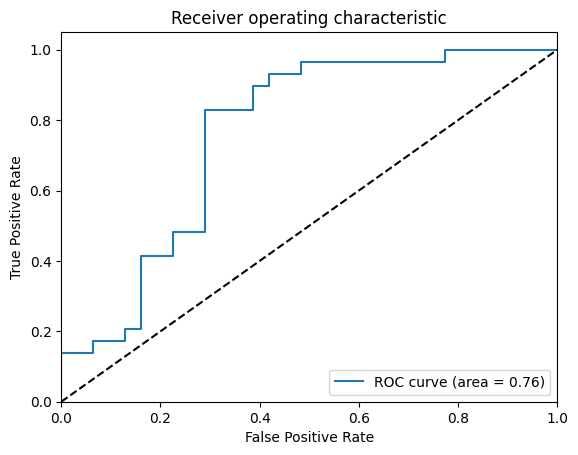

In [38]:
probs = cross_val_predict(bestEstimator_selected_channels,testData.iloc[:,:nCols-1], testData.iloc[:,nCols-1],cv=5, method="predict_proba")
probs = probs[:, 1]  # use the probability of the positive class
true_labels = testData.iloc[:,nCols-1]

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(true_labels, probs)
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


### Calibration of best classifier to predict probability outputs for all time samples

In [28]:
evalDataB = scipy.io.loadmat("BCICIV_1_mat/BCICIV_eval_ds1b.mat")

In [29]:
import sklearn
from sklearn.calibration import CalibratedClassifierCV

if type(bestEstimator_freq_band) == sklearn.svm._classes.SVC:
    bestEstimator_freq_band = CalibratedClassifierCV(bestEstimator_freq_band,cv="prefit")
    bestEstimator_freq_band.fit(calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1])

#### Calibrate SVC

In [30]:
probabilities = startRunningClassifier(evalDataB,bestEstimator_freq_band,comp,W_freq_band,trialWinStart=0.5,trialWinEnd=2.5,b=best_b,a=best_a)


In [32]:
import csv

with open("output_subject_b_original_timeWin_100Hz.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(probabilities)


In [ ]:
bestEstimator_freq_band.classes_

array([-1,  1])

In [ ]:
channelNums = dict()

for i in range(2,nChannels+1):
    selectedChannels = list(channelOccurences.keys())[:i]
    # #It can be seen that all selected channels are in and around the sensorimotor cortex

    selectedSet = set(selectedChannels)
    selectedIdxs = [idx for idx,ch in enumerate(channelNames) if ch in selectedSet]

    accVal = 0
    bestAccVal = 0
    bestEstimator_selected_channels = None
    for model in ["Logistic Regression","LDA","SVC"]:
        accVal, estimator =  testClassifier(dataB,0.5,4.5,0.7,model,b=best_b,a=best_a,selectedChannels=selectedIdxs)
        
        if accVal > bestAccVal:
            bestAccVal = accVal
            bestEstimator_selected_channels = estimator

    channelNums[i] = bestAccVal




ValueError: too many values to unpack (expected 2)

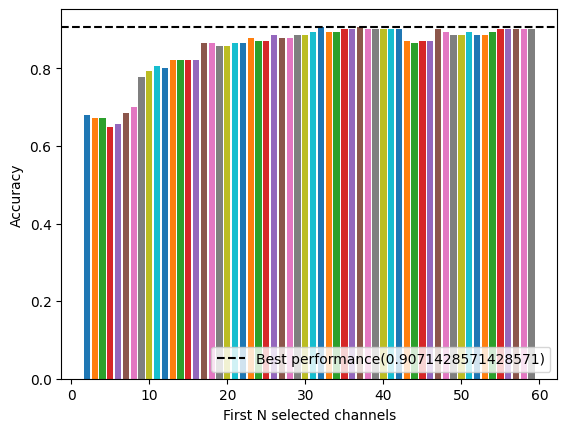

In [ ]:
bestY = 0
for x, y in channelNums.items():
    bestY= max(bestY,y)
    plt.bar(x,y)

plt.xlabel("First N selected channels")
plt.ylabel("Accuracy")
plt.axhline(y=bestY, color='black', ls='--', lw=1.5, label=f"Best performance({bestY})")
plt.legend(loc='lower right')
